# Imports

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import gurobipy as gp
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_path = Path("../project_1_git/FINA60602A/data_will/48_Industry_Portfolios.CSV")
df = pd.read_csv(data_path, index_col=0)
df.index = pd.to_datetime(df.index, format="%Y%m")  # clean the index to be datetime

# constants
start_date = "2019-12-01"
N = 48
risk_free = 0.4
df = df.loc[df.index >= start_date, :]  # select last 5 years
df = df.astype(dtype= 'float64')

df.describe()


,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,...,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,1.711667,0.498000,0.826500,0.516833,1.285667,-0.256500,1.378000,1.248667,0.688833,0.473333,...,0.864833,1.164500,1.599667,1.497500,1.115333,1.170167,1.306167,1.408333,1.837167,1.397500
std,6.808964,4.191801,5.076224,4.506729,5.675682,9.453468,8.880008,7.771293,4.803803,8.238356,...,5.948642,7.123999,6.113119,6.129512,6.405527,7.475411,5.145520,9.773773,7.073771,5.605092
min,-12.510000,-9.300000,-15.440000,-9.920000,-11.620000,-18.850000,-27.970000,-22.650000,-10.590000,-19.460000,...,-13.800000,-16.810000,-17.820000,-11.240000,-22.120000,-23.900000,-12.740000,-35.950000,-16.860000,-14.990000
25%,-3.070000,-2.392500,-1.555000,-2.872500,-2.317500,-6.070000,-3.892500,-4.265000,-1.852500,-5.930000,...,-3.610000,-4.275000,-1.655000,-3.090000,-2.330000,-3.362500,-2.945000,-3.252500,-3.507500,-2.347500
50%,2.445000,0.290000,1.070000,0.300000,1.445000,-0.955000,1.425000,1.290000,0.405000,0.520000,...,0.870000,0.590000,1.085000,1.590000,0.610000,1.815000,1.560000,0.850000,2.115000,1.445000
75%,5.847500,3.450000,4.380000,3.255000,5.267500,5.705000,7.442500,5.265000,3.835000,5.875000,...,5.640000,7.545000,5.327500,5.212500,5.355000,5.512500,3.782500,6.682500,6.580000,5.517500
max,16.160000,11.260000,12.680000,11.090000,12.420000,21.060000,19.330000,23.800000,11.400000,17.510000,...,11.790000,17.440000,16.110000,18.790000,18.670000,18.310000,12.820000,21.420000,16.880000,16.610000


# Functions

In [3]:
def max_sharpe_ratio(df: pd.DataFrame, exp_return: float, bound: float, short_constraint: bool) -> tuple:
    """ 
    Computes the maximum sharpe ratio for a given return

    Inputs
        df: dataframe of monthly returns, each colum is a different asset
        exp_return: expected return for the sharpe ratio
        short_constraint: if the short constraint is active
        bound: bound imposed on weights for the sake of numerical stability
    Outputs
        x: weights of the assets
        SR: max Sharpe Ratio for the return
        result: dataframe of positions 
    """
    cov = df.cov()
    mean = df.mean(axis=0)

    K = 5
    l = bound #max position size (5000%)

    # Create an empty optimization model
    m = gp.Model()
    m.setParam('OutputFlag', 0)
    m.Params.Threads = 8

    # Add variables: x[i] denotes the proportion of capital invested in stock i
    
    b = m.addMVar(len(mean), vtype=gp.GRB.BINARY, name="b")

    if short_constraint:
        x = m.addMVar(len(mean), lb=-np.inf, ub=np.inf, name="x")
        x_plus = m.addMVar(len(mean), lb= 0, ub=np.inf, name="x_plus")
        x_minus = m.addMVar(len(mean), lb= 0, ub=np.inf, name="x_minus")

        # Budget constraint: all investments sum up to 1
        m.addConstr(x == x_plus - x_minus, name= "Position_Balance")
        m.addConstr(x_plus+x_minus <= l*b, name= "Long_Indicator")
        # m.addConstr(x_plus <= l*b, name= "Long_Indicator")
        # m.addConstr(x_minus <= l*b, name= "Short_Indicator")
    else:
        x = m.addMVar(len(mean), lb=0, ub=np.inf, name="x")
        m.addConstr(x <= l*b, name= "Long_Indicator")
        m.addConstr(0 <= x, name="Long_Constraint")
    # Budget constraint: all investments sum up to 1
    
    m.addConstr(x.sum() == 1, name="Budget_Constraint")
    m.addConstr(b.sum() <= K, name="Cardinality")
    m.addConstr(x.T @ mean.to_numpy() == exp_return , name="Target_Return")

    # Minimize variance
    m.setObjective(x.T @ cov.to_numpy() @ x, gp.GRB.MINIMIZE)

    m.optimize()

    try:
        var = x.X @ cov.to_numpy() @ x.X
        rets = mean @ x.X
        SR = (rets-risk_free)/np.sqrt(m.ObjVal)

        positions = pd.Series(name="Position", data= x.X, index= mean.index)
        index = positions[abs(positions) > 1e-5].index
        result = pd.DataFrame({'mean' : df[index].mean(),
                                'var' : df[index].var()})
    except:
        return None, None, None

    return SR, x.X, result

# Constrained Optimization (Long-Only)

In [4]:
rets = np.linspace(0, 5, 100)
sharpe = np.zeros(len(rets))
weights = [None] * 250
for i in range(len(rets)):
    SR, w, _ = max_sharpe_ratio(df= df, exp_return= rets[i], bound=50, short_constraint= False)
    sharpe[i] = SR 
    weights[i] = w

Restricted license - for non-production use only - expires 2026-11-23


In [5]:
idmax = np.nanargmax(sharpe)

SR, w, position = max_sharpe_ratio(df= df, exp_return= rets[idmax], bound=50, short_constraint= False)

In [6]:
pd.DataFrame(w[w != 0], index = df.columns[w != 0], columns=["Weights"])

,Weights
Agric,0.039337
Guns,0.133824
Coal,0.221461
Chips,0.605378


In [7]:
pd.DataFrame([SR, position.loc[:,"mean"] @ w[w != 0], (position.loc[:,"mean"] @ w[w != 0] - risk_free) / SR], index= ["Sharpe Ratio", "Expected Return", "Standard Deviation"], columns=["Statistics"])

,Statistics
Sharpe Ratio,0.352712
Expected Return,2.676768
Standard Deviation,6.455037


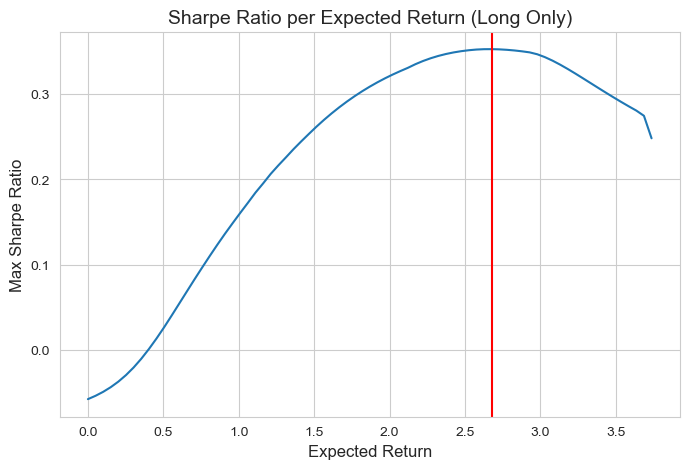

In [8]:
sns.set_style("whitegrid")

plt.figure(figsize=(8, 5))
sns.lineplot(y=sharpe, x= rets)
# Add Title and Labels
plt.title("Sharpe Ratio per Expected Return (Long Only)", fontsize=14)
plt.xlabel("Expected Return", fontsize=12)
plt.ylabel("Max Sharpe Ratio", fontsize=12)

plt.axvline(position.loc[:,"mean"] @ w[w != 0], c="red")
# Show the Plot
plt.show()

# Unconstrained Optimization 

We apply a mixed integer linear programming procedure while applying multithreading to accelerate the search procedure. We find our maxima over a larger interval initially and refine our selection by observing a more finely partitioned linspace within the interval of our optimal solution.

In [9]:
from tqdm import tqdm

In [10]:
# first 'general' search
rets = np.linspace(0, 200, 400)
sharpe = np.zeros(len(rets))
weights = [None] * len(rets)
positions = [None] * len(rets)

for i in tqdm(range(len(rets))):
    SR, w, p = max_sharpe_ratio(df= df, exp_return= rets[i], bound=50, short_constraint= True)
    sharpe[i] = SR
    weights[i] = w
    positions[i] = p

100%|█████████████████████████████████████████| 400/400 [04:53<00:00,  1.36it/s]


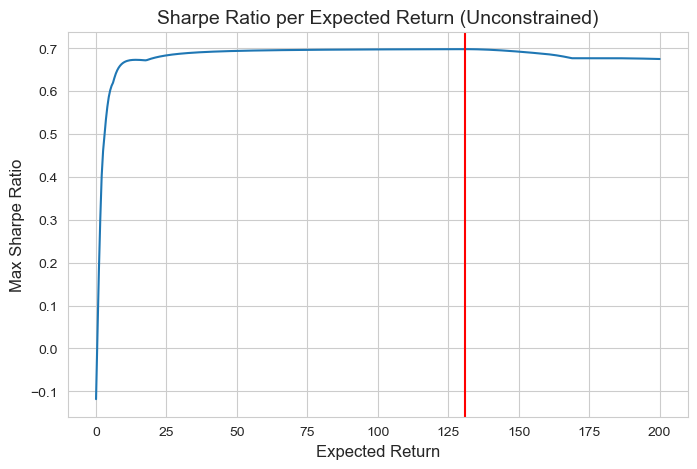

In [11]:
sns.set_style("whitegrid")

plt.figure(figsize=(8, 5))
sns.lineplot(y=sharpe, x= rets)
# Add Title and Labels
plt.title("Sharpe Ratio per Expected Return (Unconstrained)", fontsize=14)
plt.xlabel("Expected Return", fontsize=12)
plt.ylabel("Max Sharpe Ratio", fontsize=12)

w_star = weights[np.nanargmax(sharpe)]
positions_star = positions[np.nanargmax(sharpe)]
plt.axvline(positions_star.loc[:, "mean"] @ w_star[w_star != 0], c="red")

# Show the Plot
plt.show()

In [12]:
# second more 'refined' search
rets = np.linspace(120, 150, 100)
sharpe = np.zeros(len(rets))
weights = [None] * len(rets)
positions = [None] * len(rets)

for i in tqdm(range(len(rets))):
    SR, w, p = max_sharpe_ratio(df= df, exp_return= rets[i], bound=50, short_constraint= True)
    sharpe[i] = SR
    weights[i] = w
    positions[i] = p

100%|█████████████████████████████████████████| 100/100 [00:12<00:00,  7.81it/s]


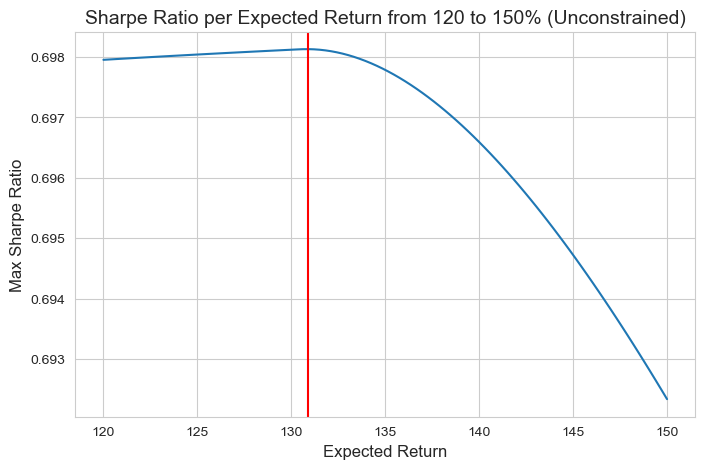

In [13]:
sns.set_style("whitegrid")

plt.figure(figsize=(8, 5))
sns.lineplot(y=sharpe, x= rets)
# Add Title and Labels
plt.title("Sharpe Ratio per Expected Return from 120 to 150% (Unconstrained)", fontsize=14)
plt.xlabel("Expected Return", fontsize=12)
plt.ylabel("Max Sharpe Ratio", fontsize=12)

w_star = weights[np.nanargmax(sharpe)]
positions_star = positions[np.nanargmax(sharpe)]
plt.axvline(positions_star.loc[:, "mean"] @ w_star[w_star != 0], c="red")

# Show the Plot
plt.show()

In [14]:
idmax = np.nanargmax(sharpe)

SR, w, position = max_sharpe_ratio(df= df, exp_return= rets[idmax], bound=50, short_constraint= True)
position

,mean,var
Agric,1.711667,46.361990
Hlth,0.497500,51.636860
Chems,0.822667,48.662901
Cnstr,2.594833,88.772754
Coal,3.569833,198.479239


In [15]:
pd.DataFrame(w[w != 0], index = df.columns[w != 0], columns=["Weights"])

,Weights
Agric,23.197823
Hlth,-23.896149
Chems,-50.000000
Cnstr,41.364706
Coal,10.333620


In [16]:
pd.DataFrame([SR, position.loc[:,"mean"] @ w[w != 0], (position.loc[:,"mean"] @ w[w != 0] - risk_free) / SR], index= ["Sharpe Ratio", "Expected Return", "Standard Deviation"], columns=["Statistics"])

,Statistics
Sharpe Ratio,0.698130
Expected Return,130.909091
Standard Deviation,186.941038


# Unconstrained Optimization with Realistic Bounds on Weights

In [40]:
rets = np.linspace(0, 40, 100)
sharpe = np.zeros(len(rets))
weights = [None] * len(rets)
positions = [None] * len(rets)

for i in tqdm(range(len(rets))):
    SR, w, p = max_sharpe_ratio(df= df, exp_return= rets[i], bound=3, short_constraint= True)
    sharpe[i] = SR
    weights[i] = w
    positions[i] = p

100%|█████████████████████████████████████████| 100/100 [00:21<00:00,  4.67it/s]


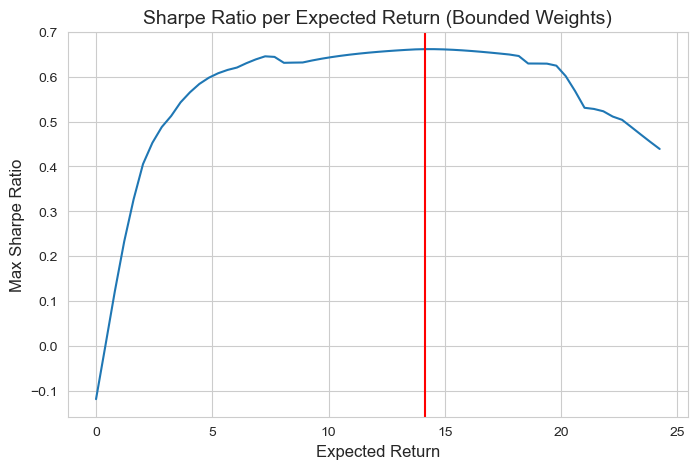

In [41]:
sns.set_style("whitegrid")

plt.figure(figsize=(8, 5))
sns.lineplot(y=sharpe, x= rets)
# Add Title and Labels
plt.title("Sharpe Ratio per Expected Return (Bounded Weights)", fontsize=14)
plt.xlabel("Expected Return", fontsize=12)
plt.ylabel("Max Sharpe Ratio", fontsize=12)

w_star = weights[np.nanargmax(sharpe)]
positions_star = positions[np.nanargmax(sharpe)]
plt.axvline(positions_star.loc[:, "mean"] @ w_star[w_star != 0], c="red")

# Show the Plot
plt.show()

In [45]:
idmax = np.nanargmax(sharpe)

SR, w, position = max_sharpe_ratio(df= df, exp_return= rets[idmax], bound=3, short_constraint= True)
position

,mean,var
Toys,-0.256500,89.368064
Chems,0.822667,48.662901
Cnstr,2.594833,88.772754
Coal,3.569833,198.479239
Chips,2.691000,58.224141


In [46]:
pd.DataFrame(w[w != 0], index = df.columns[w != 0], columns=["Weights"])

,Weights
Toys,-1.737454
Chems,-3.000000
Cnstr,2.419512
Coal,1.088883
Chips,2.229058


In [47]:
pd.DataFrame([SR, position.loc[:,"mean"] @ w[w != 0], (position.loc[:,"mean"] @ w[w != 0] - risk_free) / SR], index= ["Sharpe Ratio", "Expected Return", "Standard Deviation"], columns=["Statistics"])

,Statistics
Sharpe Ratio,0.661197
Expected Return,14.141414
Standard Deviation,20.782634
